<h1 style="color:yellow;">Sequential Data - Deep Learning</h1>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys 
sys.path.append(os.path.abspath(".."))

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    create_dataloaders, train_and_evaluate_pytorch_model, \
    analyze_correlations, perform_voting_feature_selection, log_metrics, plot_individual_metrics
from preprocess import preprocessing
pd.set_option('display.max_columns', None)

preprocessing_dir = os.path.join('figures','preprocessing')
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluatoin charts')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

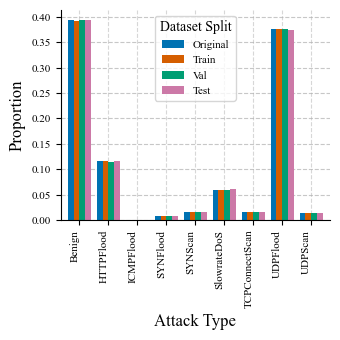

[Memory] Before GC: 1605.83 MB
[Memory] After GC: 1373.91 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


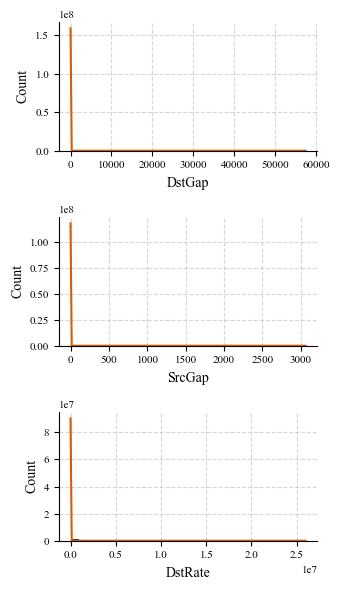

[Visualization] Plotting top 3 skewed features after transformation


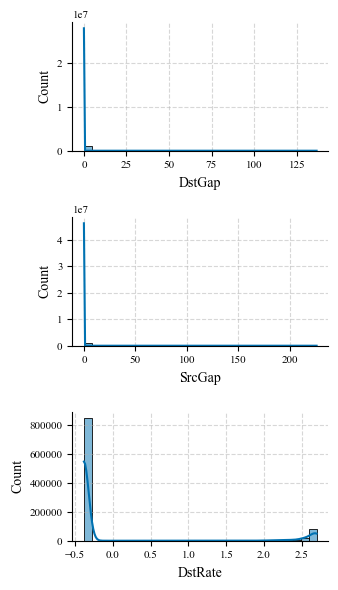

<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18  DstBytes    972695 non-null  float32
 19  Of

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Feature Selection

### Analyze correlation between features

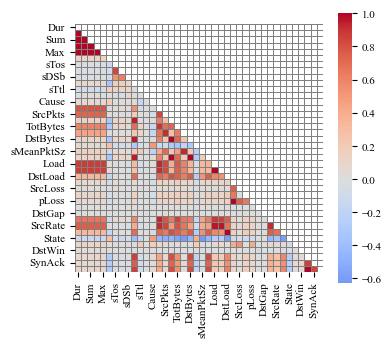


[Analysis] Features with correlation > 0.95:
  - Mean is correlated with ['Dur']
  - Sum is correlated with ['Dur', 'Mean']
  - Min is correlated with ['Dur', 'Mean', 'Sum']
  - Max is correlated with ['Dur', 'Mean', 'Sum', 'Min']
  - DstBytes is correlated with ['dDSb', 'DstPkts']
  - dMeanPktSz is correlated with ['dDSb', 'DstPkts', 'DstBytes']
  - SrcLoad is correlated with ['Load']
  - pLoss is correlated with ['Loss']
  - SrcRate is correlated with ['Load', 'SrcLoad']
  - DstRate is correlated with ['DstLoad']
  - AckDat is correlated with ['TcpRtt']


In [3]:
high_corr_features = analyze_correlations(X_train, preprocessing_dir, threshold=0.95)

### Drop correlated features

In [4]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")

gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

Dropped 11 correlated features.
[Memory] Notebook - After Dropping Correlated Features: 1987.42 MB


In [5]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

Remaining features count: 29
Remaining features list:
['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'SrcGap', 'DstGap', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']


# Arguments

In [6]:
version = 'DL'
sampling_method = 'smote'
plot_distributions = True
model_results= []

<h1 style="color:red;">Compare the results of all methods</h1>


[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 15 features...
[Filter] Completed in 0.06 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'DstPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9792

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 15 features...
[Filter] Completed in 0.11 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'TotPkts', 'DstPkts', 'TotBytes', 'Offset', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Filter Method: chi2 ---

[Filter] Starting CHI2 Feature Selection to select top 15 features...
[Filter] Completed in 0.18 seconds.
[Filter] Selected Features: ['Dur', 'dDSb', 'TotPkts',

/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


[Embedded] Completed in 31.05 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: ridge ---

[Embedded] Starting RIDGE Feature Selection to select top 15 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 54.61 seconds.
[Embedded] Selected Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: elastic_net ---

[Embedded] Starting ELASTIC_NET Feature Selection to select top 15 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 31.50 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: rf ---

[Embedded] Starting RF Feature Selection to select top 15 features...
[Embedded] Completed in 7.66 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Embedded Method: gradient_boosting ---

[Embedded] Starting GRADIENT_BOOSTING Feature Selection to select top 15 features...
[Embedded] Completed in 885.23 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'State', 'SrcWin', 'DstWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

Summary of Validation 

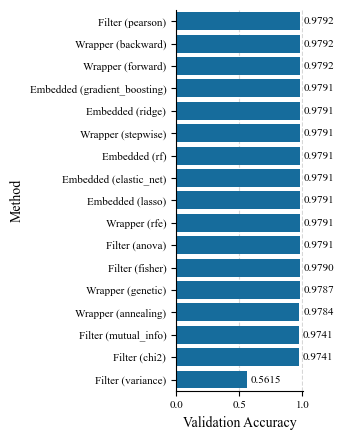


[Debugging] Feature Selection Verification

Rank 1: Filter (pearson) (Acc: 0.9792)
  Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'DstPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'State', 'SrcWin', 'TcpRtt', 'SynAck']

Rank 2: Wrapper (backward) (Acc: 0.9792)
  Features: ['sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'Loss', 'SrcLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 3: Wrapper (forward) (Acc: 0.9792)
  Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'SrcGap', 'Rate', 'State', 'SrcWin', 'TcpRtt']

Rank 4: Embedded (gradient_boosting) (Acc: 0.9791)
  Features: ['Dur', 'Proto', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 5: Embedded (ridge) (Acc: 0.9791)
  Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 

In [7]:
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=15, 
    sample_size=None, 
    top_k=3,
    file_path= preprocessing_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

## Filter the dataframes to include only selected columns

In [8]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Preprocessing

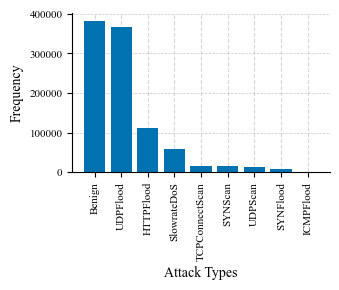

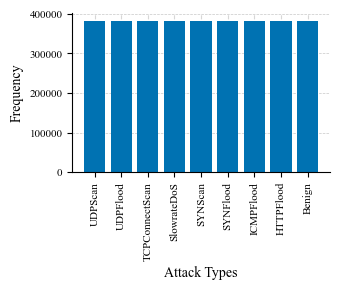


[Preprocessing] Final dataset sizes (after smote):
  - Training samples: 3438171
  - Validation samples: 121587
  - Test samples: 121587
[Memory] Notebook - Ready for Training: 2699.31 MB


In [9]:
X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val_processed, y_test_processed = preprocessing(X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_dir, version, sampling_method, plot_distributions)
print_memory_usage("Notebook - Ready for Training")

# Save the dataframes in directory

In [10]:
# 1. Define the directory to save the processed data
# You can adjust the path name as needed
save_dir = os.path.join('..', 'data frames', 'DL','15 Features')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

print(f"Saving data to: {os.path.abspath(save_dir)}")

# 2. Save the feature matrices (X)
# These are already numpy arrays (float32) from your preprocessing function
np.save(os.path.join(save_dir, 'X_train_processed.npy'), X_train_processed)
np.save(os.path.join(save_dir, 'X_val_scaled.npy'), X_val_processed)
np.save(os.path.join(save_dir, 'X_test_scaled.npy'), X_test_processed)

# 3. Save the target vectors (y)
np.save(os.path.join(save_dir, 'y_resampled.npy'), y_train_processed)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val_processed)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test_processed)

# 4. Save the label encoder classes
# This is crucial if you want to map predictions back to original names (e.g., 'Benign', 'DDoS') later
np.save(os.path.join(save_dir, 'label_classes.npy'), output_encoder.classes_)

print("All datasets saved successfully.")

Created directory: ../data frames/DL/15 Features
Saving data to: /Users/hemaali/Desktop/Master Degree Project/data frames/DL/15 Features
All datasets saved successfully.


# Deep Learning

In [11]:
import torch
import torch.nn as nn

## Check for device

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Create DataLoaders (Shared for all DL models)

In [13]:
# Note: All models in this setup use the same input shape (N, 1, F)
train_loader, val_loader = create_dataloaders(X_train_processed, y_train_processed, X_val_processed, y_val_processed, batch_size=128)

## Define models

### LSTM

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

### GRU

In [15]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### CNN

In [16]:

class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        conv_out_length = input_length - 2
        pool_out_length = conv_out_length // 2
        self.fc_input_dim = 64 * pool_out_length
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Initializing and training the models

### Getting input size and number of classes

In [17]:
input_size = X_train_processed.shape[1]
num_classes = len(np.unique(y_train_processed))

### LSTM train and evaluate


--- LSTM Model ---


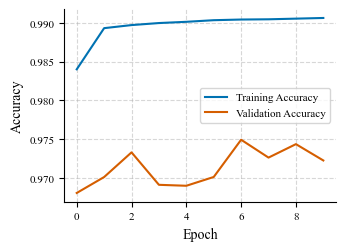

In [18]:
# --- LSTM ---
print("\n--- LSTM Model ---")
lstm_model = LSTMModel(input_size, 64, num_classes)
y_pred_lstm, t_time_lstm, p_time_lstm = train_and_evaluate_pytorch_model(
    lstm_model, train_loader, val_loader, num_epochs=10, device=device, model_name="LSTM"
)

LSTM Evaluation:
Accuracy: 0.97224210
Precision: 0.97236258
Recall: 0.97224210
F1 Score: 0.97224378
Training Time: 375.4808 seconds
Prediction Time: 0.8392 seconds
latency per sample: 0.00000690 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97405665 0.95706907 0.96548814     47821
     HTTPFlood  0.99693033 0.99650350 0.99671687     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99512195 1.00000000 0.99755501      1020
       SYNScan  0.99800200 0.99501992 0.99650873      2008
   SlowrateDoS  0.99294118 0.99445523 0.99369762      7214
TCPConnectScan  0.99796954 0.99847638 0.99822290      1969
      UDPFlood  0.95617291 0.97342156 0.96472014     45789
       UDPScan  0.99632578 0.99815951 0.99724180      1630

      accuracy                      0.97224210    121587
     macro avg  0.98972448 0.99034502 0.99001680    121587
  weighted avg  0.97236258 0.97224210 0.97224378    121587



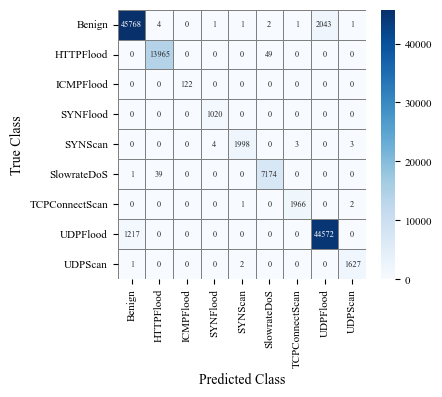

In [19]:
# arguments for evaluation function
results_file_name = 'lstm_results.txt'
cm_title = 'LSTM Confusion Matrix'

print("LSTM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_lstm, t_time_lstm, p_time_lstm, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'lstm', accuracy, precision, recall, f1, t_time_lstm, p_time_lstm)

### GRU train and evaluate


--- GRU Model ---


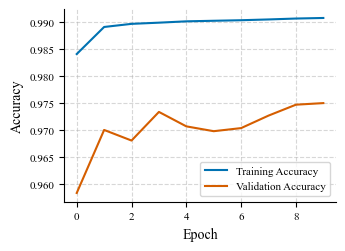

In [20]:
# --- GRU ---
print("\n--- GRU Model ---")
gru_model = GRUModel(input_size, 64, num_classes)
y_pred_gru, t_time_gru, p_time_gru = train_and_evaluate_pytorch_model(
    gru_model, train_loader, val_loader, num_epochs=10, device=device, model_name="GRU"
)

GRU Evaluation:
Accuracy: 0.97503845
Precision: 0.97597016
Recall: 0.97503845
F1 Score: 0.97503495
Training Time: 1105.3533 seconds
Prediction Time: 0.5494 seconds
latency per sample: 0.00000452 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99368842 0.94487777 0.96866860     47821
     HTTPFlood  0.99763898 0.99500500 0.99632025     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800399 0.99601594 0.99700897      2008
   SlowrateDoS  0.98994213 0.99598004 0.99295191      7214
TCPConnectScan  0.99898374 0.99847638 0.99873000      1969
      UDPFlood  0.94543943 0.99377580 0.96900521     45789
       UDPScan  0.99388753 0.99754601 0.99571341      1630

      accuracy                      0.97503845    121587
     macro avg  0.99084269 0.99129744 0.99093315    121587
  weighted avg  0.97597016 0.97503845 0.97503495    121587



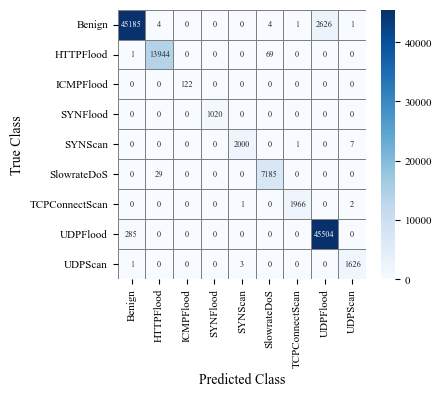

In [21]:
# arguments for evaluation function
results_file_name = 'gru_results.txt'
cm_title = 'GRU Confusion Matrix'

print("GRU Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_gru, t_time_gru, p_time_gru, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'gru', accuracy, precision, recall, f1, t_time_gru, p_time_gru)

### CNN train and evaluate


--- CNN Model ---


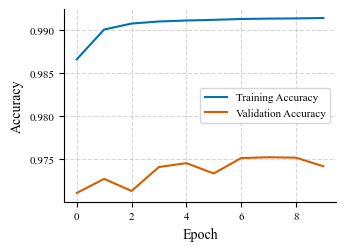

In [22]:
# --- CNN ---
print("\n--- CNN Model ---")
cnn_model = CNNModel(input_size, num_classes)
y_pred_cnn, t_time_cnn, p_time_cnn = train_and_evaluate_pytorch_model(
    cnn_model, train_loader, val_loader, num_epochs=10, device=device, model_name="CNN"
)

Logistic Regression Evaluation:
Accuracy: 0.97417487
Precision: 0.97470235
Recall: 0.97417487
F1 Score: 0.97417469
Training Time: 1739.9374 seconds
Prediction Time: 1.1697 seconds
latency per sample: 0.00000962 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98619102 0.94981284 0.96766015     47821
     HTTPFlood  0.99728436 0.99578992 0.99653658     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99512195 1.00000000 0.99755501      1020
       SYNScan  0.99800399 0.99601594 0.99700897      2008
   SlowrateDoS  0.99185083 0.99542556 0.99363498      7214
TCPConnectScan  0.99847638 0.99847638 0.99847638      1969
      UDPFlood  0.94973289 0.98617572 0.96761129     45789
       UDPScan  0.99693440 0.99754601 0.99724011      1630

      accuracy                      0.97417487    121587
     macro avg  0.99039954 0.99102693 0.99063594    121587
  weighted avg  0.97470235 0.97417487 0.97417469   

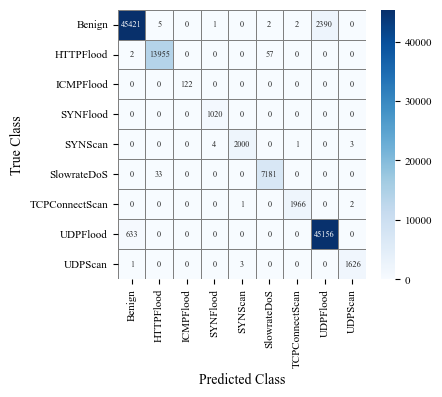

In [23]:
# arguments for evaluation function
results_file_name = 'cnn_results.txt'
cm_title = 'CNN Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_cnn, t_time_cnn, p_time_cnn, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'cnn', accuracy, precision, recall, f1, t_time_cnn, p_time_cnn)

# Bar charts

Saved DL_comparison_accuracy.pdf


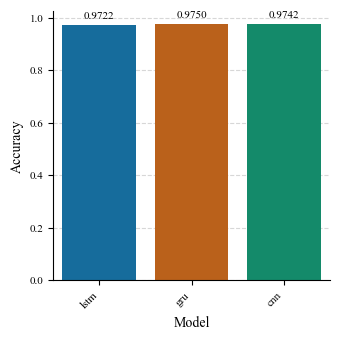

Saved DL_comparison_precision.pdf


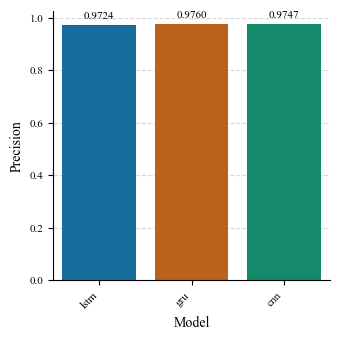

Saved DL_comparison_recall.pdf


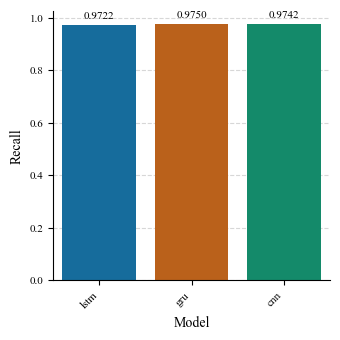

Saved DL_comparison_f1-score.pdf


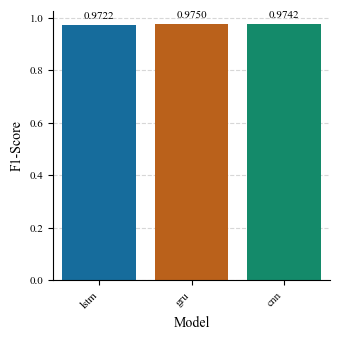

Saved DL_comparison_training_time_s.pdf


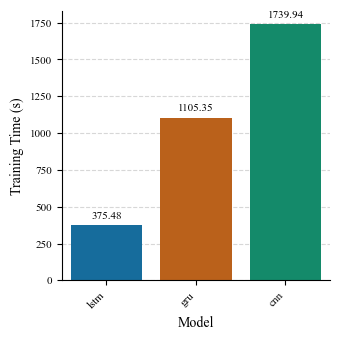

Saved DL_comparison_prediction_time_s.pdf


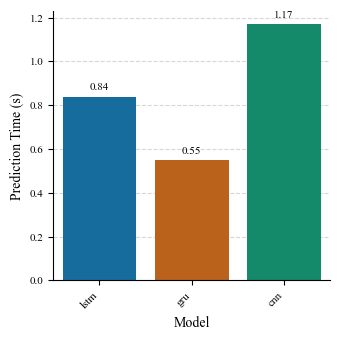

In [24]:
plot_individual_metrics(model_results, evaluation_dir, version)